### Connect to Drive

In [17]:
#from google.colab import drive
#drive.mount('/gdrive')

In [18]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [19]:
import tensorflow as tf
import keras_tuner
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [20]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = '../input/homework1/training_data_final'

In [21]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [22]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

numbers = [186,
           532,
           515,
           511,
           531,
           222,
           537,
           508,
]

# Weight classes
class_weights = {}
class_mean = sum(numbers) / len(numbers)
for i, n in enumerate(numbers):
    class_weights[i] = (1 / n) * class_mean

print(class_weights)

{0: 2.3803763440860215, 1: 0.8322368421052632, 2: 0.8597087378640776, 3: 0.8664383561643835, 4: 0.833804143126177, 5: 1.9943693693693694, 6: 0.824487895716946, 7: 0.8715551181102362}


In [23]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 96

In [24]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

def preprocess_image(image, label):
    #image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

In [25]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    class_names=labels,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    interpolation='nearest',
    validation_split=0.2,
    subset='training'
)

valid_gen = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    class_names=labels,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    interpolation='nearest',
    validation_split=0.2,
    subset='validation'
)

tg = list(train_gen.unbatch().map(lambda x, y: (x, y)))
vg = list(valid_gen.unbatch().map(lambda x, y: (x, y)))

x_train = np.asarray(list(map(lambda t: t[0], tg)))
y_train = np.asarray(list(map(lambda t: t[1], tg)))

x_val = np.asarray(list(map(lambda t: t[0], vg)))
y_val = np.asarray(list(map(lambda t: t[1],vg)))

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


In [26]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

In [27]:
train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

valid_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

valid_ds = (
    valid_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

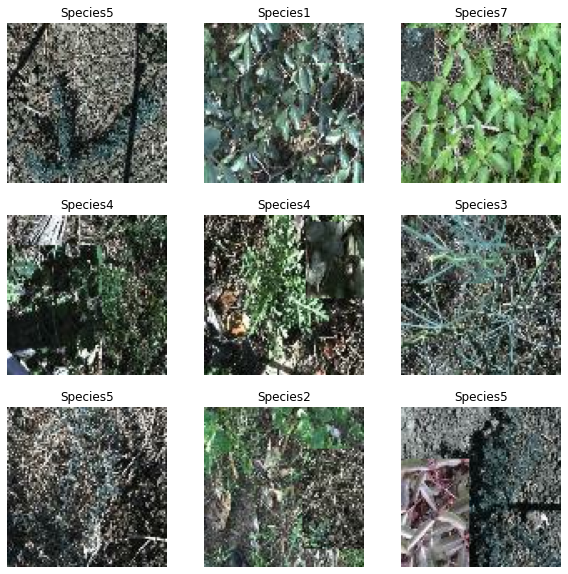

In [28]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(labels[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")


### Models metadata

In [29]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

In [30]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
# Use the supernet as feature extractor
supernet.trainable = False

#supernet.summary()
#tfk.utils.plot_model(supernet)

In [31]:
inputs = tfk.Input(shape=input_shape)
x = tfk.applications.vgg19.preprocess_input(inputs)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
Flattening (GlobalAveragePoo (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328

In [32]:
# Train the model
history = tl_model.fit(
    x = train_ds_cmu,
    validation_data = valid_ds,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
    class_weight=class_weights
).history

Epoch 1/200


2022-11-20 17:06:45.917317: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


89/89 [==============================] - 11s 33ms/step - loss: 5.7559 - accuracy: 0.2121 - val_loss: 1.6764 - val_accuracy: 0.3856
Epoch 2/200
89/89 [==============================] - 2s 24ms/step - loss: 2.7061 - accuracy: 0.2283 - val_loss: 1.6503 - val_accuracy: 0.4195
Epoch 3/200
89/89 [==============================] - 2s 24ms/step - loss: 2.2175 - accuracy: 0.2449 - val_loss: 1.7020 - val_accuracy: 0.4322
Epoch 4/200
89/89 [==============================] - 2s 24ms/step - loss: 2.0863 - accuracy: 0.2590 - val_loss: 1.7126 - val_accuracy: 0.4336
Epoch 5/200
89/89 [==============================] - 2s 24ms/step - loss: 1.9830 - accuracy: 0.2841 - val_loss: 1.6632 - val_accuracy: 0.4718
Epoch 6/200
89/89 [==============================] - 2s 24ms/step - loss: 1.9339 - accuracy: 0.3003 - val_loss: 1.6441 - val_accuracy: 0.4746
Epoch 7/200
89/89 [==============================] - 2s 25ms/step - loss: 1.8889 - accuracy: 0.3056 - val_loss: 1.6231 - val_accuracy: 0.4718
Epoch 8/200
89/89

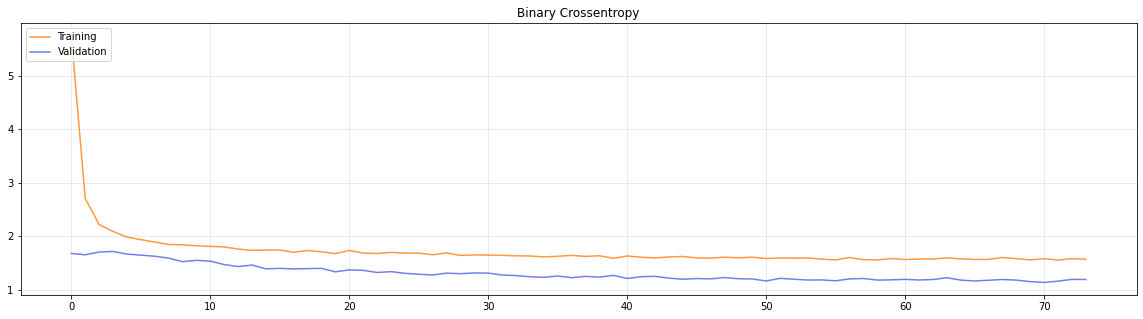

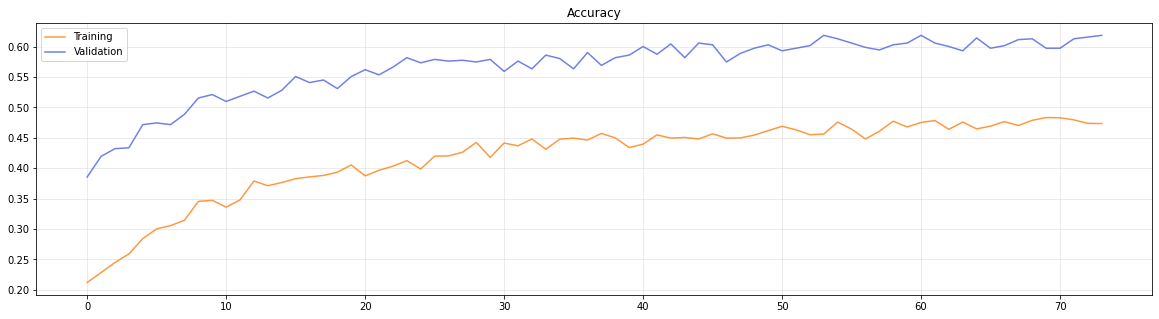

In [33]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [34]:
tl_model.save('ANN_Homework1_Model')

2022-11-20 17:10:10.690552: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [35]:
# Set all VGG layers to True
tl_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [36]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg19').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)         0         
_________________________________________________________________
v

In [37]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [38]:
# Fine-tune the model
ft_history = tl_model.fit(
    x = train_ds_cmu,
    batch_size = 64,
    epochs = 200,
    validation_data = valid_ds,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    class_weight=class_weights,
).history

Epoch 1/200
89/89 [==============================] - 5s 44ms/step - loss: 1.9105 - accuracy: 0.3144 - val_loss: 1.5668 - val_accuracy: 0.4421
Epoch 2/200
89/89 [==============================] - 3s 36ms/step - loss: 1.7211 - accuracy: 0.3931 - val_loss: 1.3910 - val_accuracy: 0.4859
Epoch 3/200
89/89 [==============================] - 3s 35ms/step - loss: 1.6228 - accuracy: 0.4605 - val_loss: 1.3904 - val_accuracy: 0.4435
Epoch 4/200
89/89 [==============================] - 3s 36ms/step - loss: 1.5550 - accuracy: 0.4852 - val_loss: 1.0566 - val_accuracy: 0.6681
Epoch 5/200
89/89 [==============================] - 3s 36ms/step - loss: 1.5169 - accuracy: 0.5131 - val_loss: 1.0839 - val_accuracy: 0.6483
Epoch 6/200
89/89 [==============================] - 3s 36ms/step - loss: 1.4769 - accuracy: 0.5522 - val_loss: 1.0705 - val_accuracy: 0.6554
Epoch 7/200
89/89 [==============================] - 3s 37ms/step - loss: 1.4176 - accuracy: 0.5730 - val_loss: 0.9156 - val_accuracy: 0.6525
Epoch 

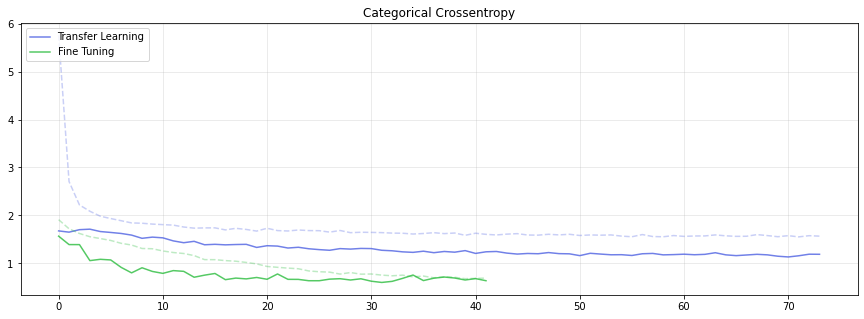

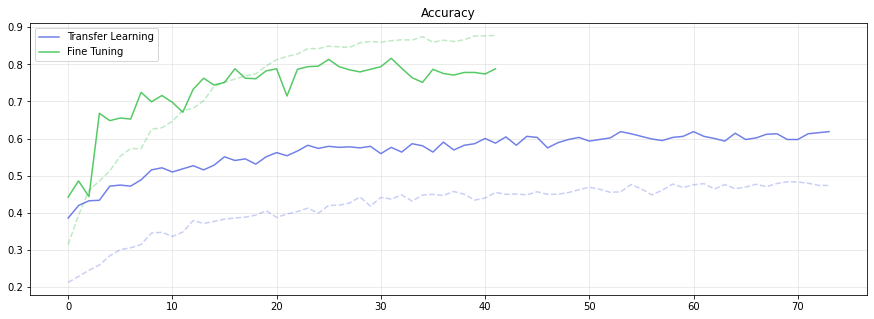

In [39]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [47]:
from sklearn.metrics import classification_report

def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    for sample in validation_dataset:
        for i in range(len(sample[0])):
            data_list.append(sample[0][i])
            label_list.append(sample[1][i])

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = tl_model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

In [48]:
evaluate_classes_performance(tl_model, valid_ds)

              precision    recall  f1-score   support

           0       0.69      0.33      0.45        33
           1       0.75      0.85      0.79        97
           2       0.84      0.89      0.87       113
           3       0.83      0.84      0.84       101
           4       0.85      0.84      0.84        93
           5       0.71      0.82      0.76        39
           6       0.88      0.89      0.89       119
           7       0.81      0.73      0.77       113

    accuracy                           0.82       708
   macro avg       0.79      0.77      0.78       708
weighted avg       0.82      0.82      0.81       708



In [49]:
import shutil
tl_model.save('ANN_Homework1_Model')
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

'/kaggle/working/ANN_Homework1_Model.zip'